# About this Notebook

Implementation of 
- **Heteroscedastic Aleatoric Uncertainty** as described in the paper [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977). 
- **Epistemic Uncertainty** using deep ensembles from [Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles](https://arxiv.org/abs/1612.01474)
- **Combined Aleatoric and Epistemic uncertainty** using the approach described in [What Uncertainties Do We Need in Bayesian Deep Learning for Computer Vision?](https://arxiv.org/abs/1703.04977), but with ensembles for epistemic uncertainty (and obviously not "in one model" because I use ensembles)


Parts of this notebook is based on [ marcobellagente93 /
Bayesian_Regression ](https://github.com/marcobellagente93/Bayesian_Regression/blob/main/Bayesian_regression_notebooks/noisy_sin_example.ipynb) (esp. dataset and plots)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

# Prepare dataset

 As an example we consider $y = sin(x)$, with $x \sim **bold text**\mathcal{N}_{0, 0.5}$ and noisy $y$

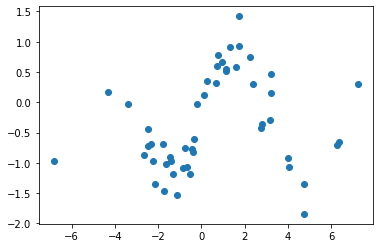

In [ ]:
# 1:1 from the original notebook

n_points = 50

x = 2*np.pi * np.random.normal(0, 0.5, n_points)
x.sort()
x = x.reshape(n_points, 1)
y = np.sin(x) + np.random.normal(-0.3, 0.3, x.shape)

# Plot to visualise target function
plt.scatter(x,y)

# Convert to tensor for model training
data = torch.Tensor(np.concatenate((x,y),-1))

# Model
Create a minimalistic model

In [ ]:
class Regressor(nn.Module):
  def __init__(self, hidden_dim=5):
    super().__init__()
    self.fc1 = nn.Linear(1,hidden_dim)

    # optionally add another fc layer, this is not required and more like a hyperparameter for tuning
    # self.fc2 = nn.Linear(hidden_dim,hidden_dim)
    self.fc2 = nn.Identity()

    self.fc3 = nn.Linear(hidden_dim,2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    # optinally add dropout. This is not required and only a hyperparameter for tuning
    # x = F.dropout(x)
    x = F.relu(self.fc2(x))
    return self.fc3(x)

Weight decay is required as the paper says:  

> it can be learned as a function of the data: [...] **with  added  weight  decay**  parameterised  by λ (and  similarly  for l1 loss).

**Hint**: Increasing `hidden_dim` to 250 allows the net to pick up the underlying function better. Both values provide usefull and interesting results.


In [ ]:
hidden_dim = 25
lr = 1e-4
wd = 1e-4

model = Regressor(hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)
model.train()

print(model)

Regressor(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Identity()
  (fc3): Linear(in_features=25, out_features=2, bias=True)
)


# train
Train the model with NLL loss as required by the paper to capture heteroscedastic aleatoric uncertainty.

In [ ]:
def train(train_model, train_optim, log_interval = 1000):
  for epoch in range(20000):
    target = data[:,1]
    
    pred = train_model(data[:,0].view(-1,1))
    mu_pred = pred[:,0]
    std_pred = pred[:,1]

    # Loss function requires variance, but i want to learn standard deviation, so i square it :)
    nll = torch.nn.GaussianNLLLoss(reduction='mean')(mu_pred, target, std_pred**2)

    nll.backward()
    train_optim.step()
    train_optim.zero_grad()

    if (epoch+1) % log_interval == 0:
      print('%.3i \t\t%.6f \t %.2e' % (epoch+1,
                                      nll.item(),
                                      train_optim.param_groups[0]['lr']), 
                                      flush=True)

In [ ]:
train(model, optimizer)

1000 		12.742968 	 1.00e-04
2000 		6.068547 	 1.00e-04
3000 		3.750786 	 1.00e-04
4000 		2.254661 	 1.00e-04
5000 		1.278135 	 1.00e-04
6000 		0.601324 	 1.00e-04
7000 		0.061576 	 1.00e-04
8000 		-0.317006 	 1.00e-04
9000 		-0.462799 	 1.00e-04
10000 		-0.551170 	 1.00e-04
11000 		-0.603879 	 1.00e-04
12000 		-0.638334 	 1.00e-04
13000 		-0.665497 	 1.00e-04
14000 		-0.684083 	 1.00e-04
15000 		-0.709124 	 1.00e-04
16000 		-0.727970 	 1.00e-04
17000 		-0.742038 	 1.00e-04
18000 		-0.752639 	 1.00e-04
19000 		-0.759553 	 1.00e-04
20000 		-0.771680 	 1.00e-04


Predict (incl std) and plot

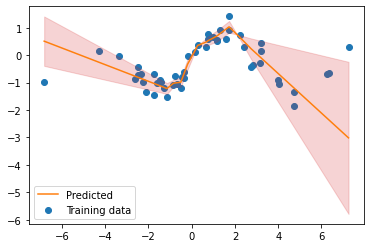

In [ ]:
x2_tensor = torch.Tensor(x).view(-1)  # value range of generated datapoints
#x2_tensor = torch.range(start=-10, end=10, step=.1)  # manual value range
x2=x2_tensor.numpy()

model.eval()
pred = model(x2_tensor.view(-1,1)).detach().numpy()
mu_pred = pred[:,0]
std_pred=pred[:,1]

plt.scatter(x, y, label='Training data')
plt.plot(x2, mu_pred, color='C1', label='Predicted')
plt.fill_between(x2, mu_pred - std_pred , mu_pred + std_pred, alpha=0.2, color='C3')
plt.legend()

# Combining Heteroscedastic Aleatoric Uncertainty and Epistemic Uncertainty
I'm using ensembles, not the epistemic approach used in the paper

In [ ]:
ensemble_size = 10

models = []
for i in range(ensemble_size):
  print(f"training model {i+1}/{ensemble_size}")

  ens_model = Regressor(hidden_dim=hidden_dim)
  ens_optimizer = torch.optim.Adam(ens_model.parameters(), lr = lr, weight_decay=wd)
  ens_model.train()
  
  train(ens_model, ens_optimizer, log_interval=5000)
  models.append(ens_model)

training model 1/10
5000 		-0.579241 	 1.00e-04
10000 		-0.819606 	 1.00e-04
15000 		-1.008720 	 1.00e-04
20000 		-1.138141 	 1.00e-04
training model 2/10
5000 		-0.648380 	 1.00e-04
10000 		-0.838462 	 1.00e-04
15000 		-0.990838 	 1.00e-04
20000 		-1.071318 	 1.00e-04
training model 3/10
5000 		-0.378163 	 1.00e-04
10000 		-0.663400 	 1.00e-04
15000 		-0.809201 	 1.00e-04
20000 		-0.870320 	 1.00e-04
training model 4/10
5000 		-0.011094 	 1.00e-04
10000 		-0.643650 	 1.00e-04
15000 		-0.905213 	 1.00e-04
20000 		-1.012955 	 1.00e-04
training model 5/10
5000 		-0.640872 	 1.00e-04
10000 		-0.809400 	 1.00e-04
15000 		-0.916409 	 1.00e-04
20000 		-0.938440 	 1.00e-04
training model 6/10
5000 		-0.202817 	 1.00e-04
10000 		-0.392302 	 1.00e-04
15000 		-0.541720 	 1.00e-04
20000 		-0.784747 	 1.00e-04
training model 7/10
5000 		-0.242390 	 1.00e-04
10000 		-0.805342 	 1.00e-04
15000 		-0.876743 	 1.00e-04
20000 		-0.957186 	 1.00e-04
training model 8/10
5000 		-0.602764 	 1.00e-04
10000 	

Calculate std for combined approach and plot (epistemic + aleatoric)

(-3.0, 3.0)

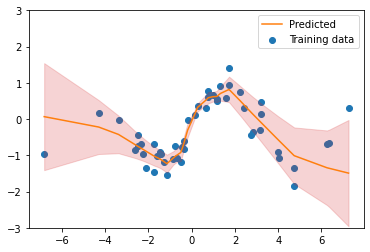

In [ ]:
# generate predictions with each model of the ensemble
mu_preds = []
std_preds = []
for i in range(len(models)):
  cur_model = models[i]
  cur_model.eval()
  
  pred = cur_model(x2_tensor.view(-1,1)).detach().numpy()
  mu_preds.append(pred[:,0])
  # To avoid negative std values and mimic the training behavior .abs() is required here
  std_preds.append(abs(pred[:,1]))


# calculate final mean/std
mu_pred = np.empty(len(mu_preds[0]))
std_pred = np.empty(len(mu_preds[0]))

## reformat predictions to allow easier calculations (switching rows to columns)
mu_preds = np.stack(mu_preds).transpose(1,0)
std_preds = np.stack(std_preds).transpose(1,0)

## do std/var calculation according to paper
## do mean calculation by taking mean of the predictions
for i in range(len(mu_pred)):
  mu_pred[i] = np.mean(mu_preds[i])

  var = np.mean(mu_preds[i]**2)-np.mean(mu_preds[i])**2+np.mean(std_preds[i]**2)
  std_pred[i] = var ** 0.5


# plot
plt.scatter(x, y, label='Training data')
plt.plot(x2, mu_pred, color='C1', label='Predicted')
plt.fill_between(x2, mu_pred - std_pred , mu_pred + std_pred, alpha=0.2, color='C3')
plt.legend()
plt.ylim([-3,3])

Using the same ensemble and only plot the **epistemic uncertainty**

(-3.0, 3.0)

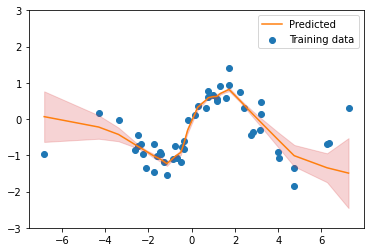

In [ ]:
# calculate final mean/std
mu_pred = np.empty(len(x))
std_pred = np.empty(len(x))

## do std/var calculation according to paper
## do mean calculation by taking mean of the predictions
for i in range(len(mu_pred)):
  mu_pred[i] = np.mean(mu_preds[i])
  std_pred[i] = np.std(mu_preds[i])


# plot
x2=x2_tensor.numpy()
plt.scatter(x, y, label='Training data')
plt.plot(x2, mu_pred, color='C1', label='Predicted')
plt.fill_between(x2, mu_pred - std_pred , mu_pred + std_pred, alpha=0.2, color='C3')
plt.legend()
plt.ylim([-3,3])

# End of Notebook / Playground
Everything below is not relevant anymore. There might only be some code for additional plots or testing stuff, etc. 

1000 		14.317835 	 1.00e-04
2000 		0.977409 	 1.00e-04
3000 		0.148420 	 1.00e-04
4000 		-0.132658 	 1.00e-04
5000 		-0.280357 	 1.00e-04
6000 		-0.396307 	 1.00e-04
7000 		-0.489838 	 1.00e-04
8000 		-0.572982 	 1.00e-04
9000 		-0.613308 	 1.00e-04
10000 		-0.635032 	 1.00e-04
11000 		-0.651168 	 1.00e-04
12000 		-0.667040 	 1.00e-04
13000 		-0.684925 	 1.00e-04
14000 		-0.703574 	 1.00e-04
15000 		-0.723241 	 1.00e-04
16000 		-0.745132 	 1.00e-04
17000 		-0.807596 	 1.00e-04
18000 		-0.815089 	 1.00e-04
19000 		-0.825172 	 1.00e-04
20000 		-0.839025 	 1.00e-04


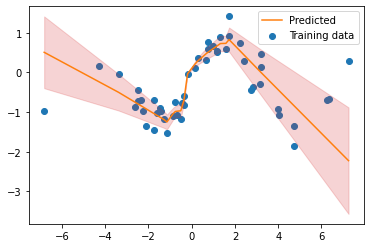

In [ ]:
# just plotting another variant of the heteroscedastic aleatoric variant
# ignore code here, it's just quick copy & pasta, only the plot is of interest

model = Regressor(hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=wd)
model.train()

train(model, optimizer)

model.eval()
pred = model(x2_tensor.view(-1,1)).detach().numpy()
mu_pred = pred[:,0]
std_pred=pred[:,1]

plt.scatter(x, y, label='Training data')
plt.plot(x2, mu_pred, color='C1', label='Predicted')
plt.fill_between(x2, mu_pred - std_pred , mu_pred + std_pred, alpha=0.2, color='C3')
plt.legend()

In [ ]:
y

array([[-0.9697556 ],
       [ 0.170082  ],
       [-0.03316577],
       [-0.86360984],
       [-0.72919853],
       [-0.43884165],
       [-0.69004924],
       [-0.9720638 ],
       [-1.34985018],
       [-0.69341067],
       [-1.46039371],
       [-1.02615549],
       [-0.90018767],
       [-0.96954601],
       [-1.18003729],
       [-1.5407425 ],
       [-1.088512  ],
       [-0.75417138],
       [-1.06236482],
       [-1.17886902],
       [-0.77831015],
       [-0.81846036],
       [-0.60545833],
       [-0.03060882],
       [ 0.11539992],
       [ 0.35458157],
       [ 0.31219554],
       [ 0.59751082],
       [ 0.78182994],
       [ 0.65874944],
       [ 0.54927625],
       [ 0.50820014],
       [ 0.90841181],
       [ 0.58647167],
       [ 0.92737703],
       [ 1.42093537],
       [ 0.74620022],
       [ 0.30047689],
       [-0.42961458],
       [-0.35695617],
       [-0.29142044],
       [ 0.14479839],
       [ 0.45846909],
       [-0.91665724],
       [-1.06273017],
       [-1